In [1]:
# 0. 환경 설정
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
from pytz import timezone

In [2]:
# 1. 하이퍼파라미터 설정
RANDOM_SEED = 4242
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 20
IMG_SIZE = 32
NUM_CLASSES = 10

In [3]:
# 2. 모델의 정확도를 계산하는 함수
def get_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            _, probabilities = model(images)
            _, predicted_labels = torch.max(probabilities, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / total_predictions

In [4]:
# 3. 학습 손실과 검증 손실을 시각화
def plot_loss(train_loss, val_loss):
    plt.style.use("grayscale")
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.plot(train_loss, color="green", label="Training Loss")
    ax.plot(val_loss, color="red", label="Validation Loss")
    ax.set(title="Loss Over Epochs", xlabel="EPOCH", ylabel="LOSS")
    ax.legend()
    fig.show()
    plt.style.use("default")

In [5]:
# 4. 검증 데이터셋을 사용하여 모델의 성능을 평가
def validate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파와 손실 기록하기
        logits, _ = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

    epoch_loss = total_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [6]:
# 5. 모델 학습 함수
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits, _ = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [7]:
# 6. 전체 학습 루프
def training_loop(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    epochs,
    device,
    print_every=1,
):

    best_loss = 1e10
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):

        # training
        model, optimizer, train_loss = train(
            train_loader, model, criterion, optimizer, device
        )
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(
                datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
                "--- ",
                f"Epoch: {epoch}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}",
            )

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [8]:
# 7. LeNet5 모델 정의
class LeNet5(nn.Module):

    def __init__(self, num_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=num_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probabilities = F.softmax(logits, dim=1)
        return logits, probabilities

# class LeNet5(nn.Module):
#     def __init__(self):
#         super(LeNet5, self).__init__()
#         self.c1 = nn.Conv2d(1, 6, kernel_size=5)
#         self.s2 = nn.AvgPool2d(2)

#         # C3 레이어는 16개의 출력을 생성하지만, 각 출력은 6개의 입력 중 일부 연결
#         self.c3 = nn.ModuleList([nn.Conv2d(3, 1, kernel_size=5) for _ in range(6)] + [nn.Conv2d(4, 1, kernel_size=5) for _ in range(6)] + [nn.Conv2d(6, 1, kernel_size=5) for _ in range(4)])
#         self.s4 = nn.AvgPool2d(2)
#         self.c5 = nn.Conv2d(16, 120, kernel_size=5)
#         self.fc1 = nn.Linear(120, 84)
#         self.fc2 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = F.tanh(self.c1(x))
#         x = self.s2(x)

#         # C3 레이어의 비대칭 연결
#         c3_outputs = []
#         c3_outputs.append(self.c3[0](x[:, [0, 1, 2], :, :]))
#         c3_outputs.append(self.c3[1](x[:, [1, 2, 3], :, :]))
#         c3_outputs.append(self.c3[2](x[:, [2, 3, 4], :, :]))
#         c3_outputs.append(self.c3[3](x[:, [3, 4, 5], :, :]))
#         c3_outputs.append(self.c3[4](x[:, [0, 4, 5], :, :]))
#         c3_outputs.append(self.c3[5](x[:, [0, 1, 5], :, :]))
#         c3_outputs.append(self.c3[6](x[:, [0, 1, 2, 3], :, :]))
#         c3_outputs.append(self.c3[7](x[:, [1, 2, 3, 4], :, :]))
#         c3_outputs.append(self.c3[8](x[:, [2, 3, 4, 5], :, :]))
#         c3_outputs.append(self.c3[9](x[:, [0, 3, 4, 5], :, :]))
#         c3_outputs.append(self.c3[10](x[:, [0, 1, 4, 5], :, :]))
#         c3_outputs.append(self.c3[11](x[:, [0, 1, 2, 5], :, :]))
#         c3_outputs.append(self.c3[12](x[:, [0, 1, 3, 4], :, :]))
#         c3_outputs.append(self.c3[13](x[:, [1, 2, 4, 5], :, :]))
#         c3_outputs.append(self.c3[14](x[:, [0, 2, 3, 5], :, :]))
#         c3_outputs.append(self.c3[15](x))

#         x = torch.cat(c3_outputs, dim=1)
#         x = self.s4(x)
#         x = F.tanh(self.c5(x))
#         x = torch.flatten(x, 1)
#         x = F.tanh(self.fc1(x))
#         x = self.fc2(x)
#         return x

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15943985.22it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 474158.70it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4439584.43it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2046683.37it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Train dataset size: 60000
Validation dataset size: 10000


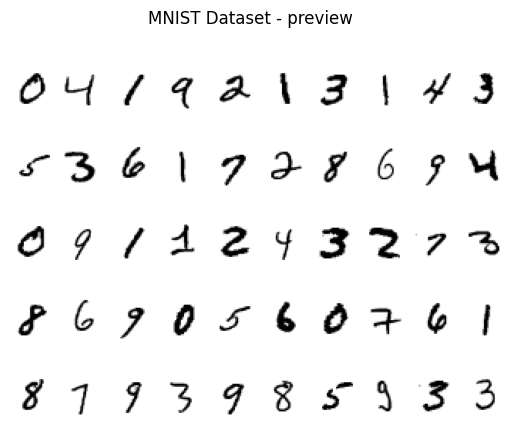

In [9]:
# 8. transforms 정의하기
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

# 9. 데이터셋 다운로드 및 생성
train_dataset = datasets.MNIST(
    root="mnist_data", train=True, transform=transform, download=True
)

valid_dataset = datasets.MNIST(root="mnist_data", train=False, transform=transform)

# 10. 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 11. 불러온 MNIST 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis("off")
    plt.imshow(train_dataset.data[index], cmap="gray_r")
fig.suptitle("MNIST Dataset - preview")

# 데이터셋 크기 출력
print(f"Train dataset size: {len(train_dataset)}")  # Train dataset size: 60000
print(
    f"Validation dataset size: {len(valid_dataset)}"
)  # Validation dataset size: 10000

21:53:55 ---  Epoch: 0	Train loss: 2.2935	Valid loss: 2.2748	Train accuracy: 24.54	Valid accuracy: 24.77
21:54:24 ---  Epoch: 1	Train loss: 2.2390	Valid loss: 2.1750	Train accuracy: 54.86	Valid accuracy: 56.46
21:54:53 ---  Epoch: 2	Train loss: 1.9945	Valid loss: 1.7022	Train accuracy: 62.02	Valid accuracy: 63.17
21:55:20 ---  Epoch: 3	Train loss: 1.3962	Valid loss: 1.1007	Train accuracy: 73.01	Valid accuracy: 73.90
21:55:49 ---  Epoch: 4	Train loss: 0.9425	Valid loss: 0.7898	Train accuracy: 80.22	Valid accuracy: 80.91
21:56:17 ---  Epoch: 5	Train loss: 0.7190	Valid loss: 0.6330	Train accuracy: 83.46	Valid accuracy: 84.16
21:56:44 ---  Epoch: 6	Train loss: 0.5977	Valid loss: 0.5391	Train accuracy: 85.47	Valid accuracy: 86.08
21:57:12 ---  Epoch: 7	Train loss: 0.5217	Valid loss: 0.4774	Train accuracy: 86.78	Valid accuracy: 87.51
21:57:40 ---  Epoch: 8	Train loss: 0.4699	Valid loss: 0.4335	Train accuracy: 87.67	Valid accuracy: 88.50
21:58:08 ---  Epoch: 9	Train loss: 0.4325	Valid loss: 0

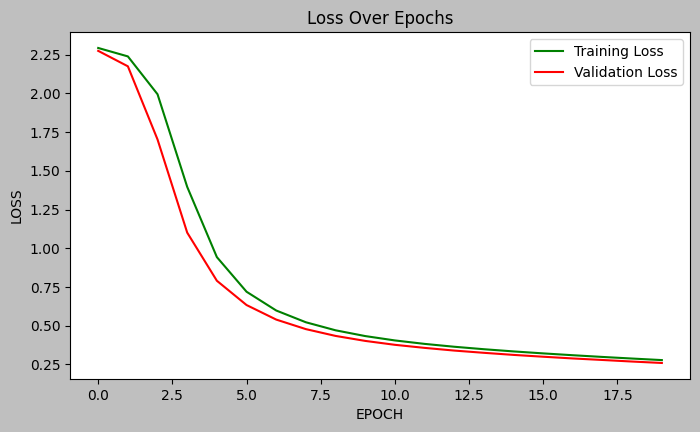

In [10]:
# 12. 학습 진행
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, EPOCHS, DEVICE
)

22:08:29 ---  Epoch: 0	Train loss: 0.2362	Valid loss: 0.0958	Train accuracy: 97.08	Valid accuracy: 97.09
22:08:57 ---  Epoch: 1	Train loss: 0.0834	Valid loss: 0.0662	Train accuracy: 98.22	Valid accuracy: 97.95
22:09:26 ---  Epoch: 2	Train loss: 0.0574	Valid loss: 0.0542	Train accuracy: 98.76	Valid accuracy: 98.24
22:09:54 ---  Epoch: 3	Train loss: 0.0464	Valid loss: 0.0536	Train accuracy: 98.89	Valid accuracy: 98.42
22:10:22 ---  Epoch: 4	Train loss: 0.0367	Valid loss: 0.0491	Train accuracy: 99.16	Valid accuracy: 98.47
22:10:51 ---  Epoch: 5	Train loss: 0.0302	Valid loss: 0.0440	Train accuracy: 99.36	Valid accuracy: 98.58
22:11:19 ---  Epoch: 6	Train loss: 0.0264	Valid loss: 0.0523	Train accuracy: 99.29	Valid accuracy: 98.39
22:11:47 ---  Epoch: 7	Train loss: 0.0231	Valid loss: 0.0634	Train accuracy: 99.09	Valid accuracy: 98.07
22:12:15 ---  Epoch: 8	Train loss: 0.0201	Valid loss: 0.0437	Train accuracy: 99.55	Valid accuracy: 98.70
22:12:43 ---  Epoch: 9	Train loss: 0.0179	Valid loss: 0

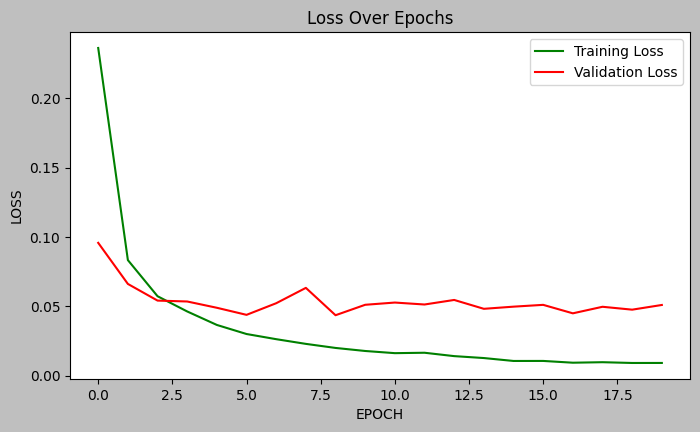

In [18]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, EPOCHS, DEVICE
)